In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Force analysis of ActuAtor

Summary of protocol for estimating forces on the membrane. Nuclei were traced from the EM images manually using Fiji. Assuming the Helfrich-Canham-Evans and surface energy of the membrane,

$$E =  \underbrace{\int_\Omega \kappa_b H^2 dA}_{E_b} + \underbrace{\int_\Omega \sigma dA}_{E_\sigma},$$

where $\kappa_b$ is the bending modulus, $H$ is the mean curvature given by the two principal curvatures, $(k_1 + k_2)/2$,  $\sigma$ is the prescribed constant surface tension, and $dA$ the area element. Given that the segmented EM images are plane curves, we assume naively that the out of plane principal curvature is naught ($k_2 = 0$). Rewriting as an energy density (per length) and simplifying,

$$\frac{E_b}{l} =\frac{\kappa_b}{4} \int_C k_1^2 ds,$$

and 

$$\frac{E_\sigma}{l} =  \sigma \int_C ds,$$ 


where $l$ is the depth relating the integrals over area, $\Omega$, and the plane curve, $C$; $ds$ is the arc-length element. To obtain the areal force density $f$ such that $f ds = -\nabla (E/l)$, we use automatic differentiation using `jax`. Note that $f$ is independent of the length scale $l$.  

## Analysis

In [2]:
import math
from collections import defaultdict
from functools import partial
from pathlib import Path

from PIL import Image
from scipy.interpolate import splev, splprep
from tqdm.auto import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from jax import jit
from jax.config import config

config.update("jax_enable_x64", True)

import automembrane.util as u
from automembrane.energy import ClosedPlaneCurveMaterial
from automembrane.integrator import fwd_euler_integrator

from actuator_constants import *

u.matplotlibStyle(small=10, medium=12, large=14)


Assuming bending modulus $1\times10^{-19}$ J and modest membrane tension $0.05$ mN/m.

In [3]:
parameters = {
    "Kb": 0.1 / 4,  # Bending modulus (pN um; original 1e-19 J)
    "Ksg": 50,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "Ksl": 1,
}

mem = ClosedPlaneCurveMaterial(**parameters)

In [4]:
## Benchmarking playground
coords = np.loadtxt(files[0])
coords = np.vstack((coords, coords[0]))

c, e, f = fwd_euler_integrator(coords, mem, 2, 5e-6, True)

print([i.shape for i in [c, e, f]])

# print(c)
e = mem.energy(coords)
f = mem.force(coords)

e2, f2 = mem.energy_force(coords)

print("Energy:", e, type(e), e.shape, sum(e))
print("")
print("Forces by jacrev:", type(f), f.shape, sum(f).shape)

print(np.allclose(e, e2))
print(np.allclose(f, f2))

# a, vjp = jax.vjp(mem._energy, coords)
# (J,) = jax.vmap(vjp, in_axes=0)(jax.numpy.eye(len(a)))

# J_fromvjp, = vjp(np.array([1.,1.,1.]))

# print("")
# print("allclose(J, f):", np.allclose(J, f))

# print("")
# print("J_vjp, f:", np.allclose(J_fromvjp, sum(f)), np.amax(np.abs(J_fromvjp-sum(f))))

# j0, = vjp(np.array([1.,0.,0.]))
# j1, = vjp(np.array([0.,1.,0.]))
# j2, = vjp(np.array([0.,0.,1.]))

# print(j0.shape, j1.shape, j2.shape)

# print("")
# print(np.allclose(sum(f), (j0+j1+j2)))
# print(np.allclose(j0+j1+j2, J_fromvjp))
# print(np.allclose(sum(f), J_fromvjp))


Energy relaxation:   0%|          | 0/3 [00:00<?, ?it/s]

[(3, 217, 2), (3, 3), (3, 3, 217, 2)]
Energy: [1.70422807e+00 2.87920556e+03 3.51239700e+01] <class 'jaxlib.xla_extension.DeviceArray'> (3,) 2916.0337600893886

Forces by jacrev: <class 'jaxlib.xla_extension.DeviceArray'> (3, 217, 2) (217, 2)
True
True


We iterate over the segmentations. To ensure that the discrete curves are sufficiently sampled, we parameterize the curve using a B-spline and resample evenly. We perform `n_iter` steps of forward Euler energy relaxation to smooth out artifacts of the discretization. We choose the sum of half the length of each incident edge to be the dual length, $ds_i$, of the $i^{\text{th}}$ vertex, $v_i$.

In [5]:
# n_vertices = 800  # Number of vertices in resampling
target_edge_length = 0.05  # target edge length in um for resampling

total_time = 0.05
dt = 5e-6  # Timestep
n_iter = math.floor(total_time / dt)  # Number of relaxation steps
data = defaultdict(dict)

for file in files:
    k = file.stem

    print("Processing:", k)
    original_coords = np.loadtxt(file)
    original_coords = np.vstack(
        (original_coords, original_coords[0])
    )  # Energy expects last point to equal first
    data[k]["original_coords"] = original_coords

    total_length = np.sum(
        np.linalg.norm(
            np.roll(original_coords[:-1], -1, axis=0) - original_coords[:-1], axis=1
        )
    )

    n_vertices = math.floor(total_length / target_edge_length)
    print(f"  Resampling to {n_vertices} vertices")
    # Periodic cubic B-spline interpolation with no smoothing (s=0)
    tck, _ = splprep([original_coords[:, 0], original_coords[:, 1]], s=0, per=True)
    data[k]["spline"] = tck

    xi, yi = splev(np.linspace(0, 1, n_vertices), tck)
    coords = np.hstack((xi.reshape(-1, 1), yi.reshape(-1, 1)))

    # Perform energy relaxation
    relaxed_coords = coords
    if n_iter > 0:
        relaxed_coords, energy_log = fwd_euler_integrator(
            relaxed_coords, mem, n_steps=n_iter, dt=dt
        )
        print(
            f"  DELTA E: {energy_log[-1] - energy_log[0]}; E_before: {energy_log[0]}; E_after: {energy_log[-1]}"
        )

    data[k]["relaxed_coords"] = relaxed_coords

    # Compute dual length
    dc = np.roll(relaxed_coords[:-1], -1, axis=0) - relaxed_coords[:-1]
    edgeLengths = np.linalg.norm(dc, axis=1)
    dualLengths = ((edgeLengths + np.roll(edgeLengths, 1)) / 2.0).reshape(-1, 1)
    dualLengths = np.vstack((dualLengths, dualLengths[0]))
    data[k]["dualLengths"] = dualLengths

    data[k]["relaxed_forces"] = sum(mem.force(relaxed_coords)) / dualLengths


Processing: 34D-grid2-s3-acta1_001_16
  Resampling to 1151 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [  -3.10177646 -125.54724953   10.08582731]; E_before: [4.02371928e+00 2.88831616e+03 4.98947587e-01]; E_after: [9.21942820e-01 2.76276891e+03 1.05847749e+01]
Processing: 34D-grid3-ActA1_007_16
  Resampling to 872 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [ -2.58841453 -91.43318956   1.35875177]; E_before: [2.73533654e+00 2.18823996e+03 3.11156639e-01]; E_after: [1.46922011e-01 2.09680677e+03 1.66990841e+00]
Processing: 34D-grid3-ActA1_013_16
  Resampling to 846 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [  -4.13904562 -115.25569502    1.14373672]; E_before: [4.29640125e+00 2.12674475e+03 1.24370365e+00]; E_after: [1.57355631e-01 2.01148906e+03 2.38744037e+00]
Processing: 34D-grid2-s2_002_16
  Resampling to 1035 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [ -11.05740027 -261.47033646   11.19484783]; E_before: [  11.8064614  2606.43771439    3.15158131]; E_after: [7.49061125e-01 2.34496738e+03 1.43464291e+01]
Processing: 34D-grid2-s5_005_16
  Resampling to 1107 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [ -12.70026728 -337.35789786   30.5872657 ]; E_before: [  14.34797719 2789.914816      3.44757264]; E_after: [1.64770990e+00 2.45255692e+03 3.40348383e+01]
Processing: 34D-grid3-ActA1_020_16
  Resampling to 1046 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [  -5.68671381 -193.00965228   13.19080227]; E_before: [6.27909916e+00 2.62978437e+03 1.44306495e+00]; E_after: [5.92385351e-01 2.43677471e+03 1.46338672e+01]
Processing: 34D-grid3-s6_005_16
  Resampling to 914 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [  -4.94913648 -122.73424069    5.73282781]; E_before: [5.11632559e+00 2.29780318e+03 8.61744687e-01]; E_after: [1.67189106e-01 2.17506894e+03 6.59457250e+00]
Processing: 34D-grid2-s3_028_16
  Resampling to 838 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [  -4.57997602 -111.75321566    6.21391918]; E_before: [4.73174942e+00 2.10479148e+03 6.85270562e-01]; E_after: [1.51773393e-01 1.99303827e+03 6.89918974e+00]
Processing: 34D-grid3-ActA1_001_16
  Resampling to 828 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [ -4.70381978 -93.4163095    0.45034571]; E_before: [4.78507830e+00 2.08236070e+03 7.53173704e-01]; E_after: [8.12585218e-02 1.98894439e+03 1.20351941e+00]
Processing: 34D-grid3-ActA1_002_16
  Resampling to 767 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [ -5.53213889 -80.30266462   0.14213095]; E_before: [5.60653838e+00 1.92451485e+03 4.29992257e-01]; E_after: [7.43994893e-02 1.84421219e+03 5.72123202e-01]
Processing: 34D-grid3-ActA1_003_16
  Resampling to 839 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [ -3.95323838 -76.70882046   0.35712622]; E_before: [4.02362682e+00 2.10663109e+03 3.34152724e-01]; E_after: [7.03884403e-02 2.02992227e+03 6.91278939e-01]
Processing: 34D-grid3-ActA1_004_16
  Resampling to 830 vertices


Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

  DELTA E: [ -2.80667388 -78.50226922   0.28284061]; E_before: [2.88239026e+00 2.08393814e+03 5.97559890e-01]; E_after: [7.57163792e-02 2.00543587e+03 8.80400503e-01]


Processing 34D-grid2-s3-acta1_001_16
[ 9.86603    27.11382143] [ 9.10714677 28.4839871 ]


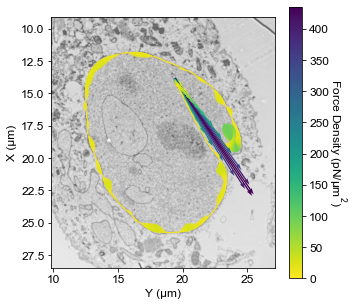

Processing 34D-grid3-ActA1_007_16
[ 8.90702791 28.6397276 ] [12.0004415  29.32609811]


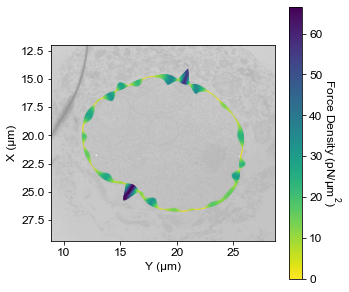

Processing 34D-grid3-ActA1_013_16
[ 8.52105352 27.55973923] [10.21177337 27.02221446]


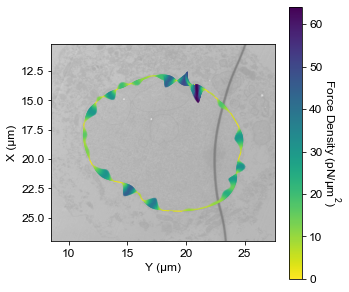

Processing 34D-grid2-s2_002_16
[13.4811189 30.2693258] [ 7.1230267  29.19736296]


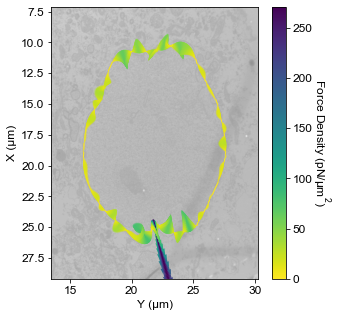

Processing 34D-grid2-s5_005_16
[10.60931677 29.2550542 ] [ 3.2855057  23.75486745]


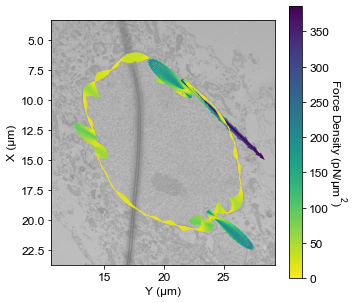

Processing 34D-grid3-ActA1_020_16
[ 8.0920828  28.36193248] [ 3.47624062 23.32234637]


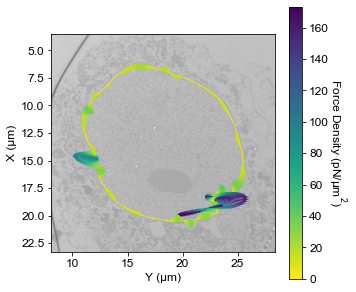

Processing 34D-grid3-s6_005_16
[11.05673887 29.2639847 ] [ 5.80753486 25.76014732]


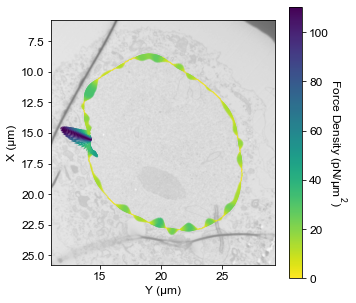

Processing 34D-grid2-s3_028_16
[11.47685205 28.07837758] [ 4.7817987  23.79739787]


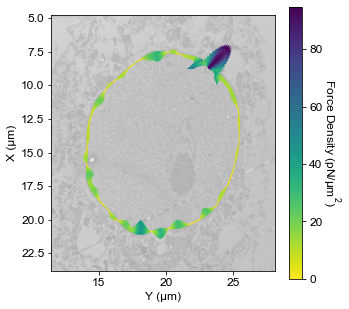

Processing 34D-grid3-ActA1_001_16
[ 3.94919882 21.64928044] [11.47362906 29.61970738]


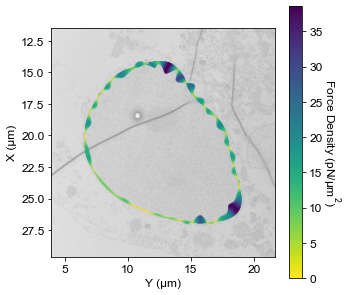

Processing 34D-grid3-ActA1_002_16
[ 5.52415168 22.41808515] [13.67818279 30.74307946]


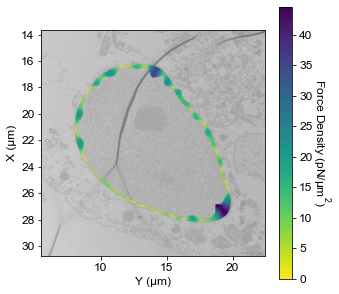

Processing 34D-grid3-ActA1_003_16
[ 4.82281509 22.48589488] [11.47170687 30.23930787]


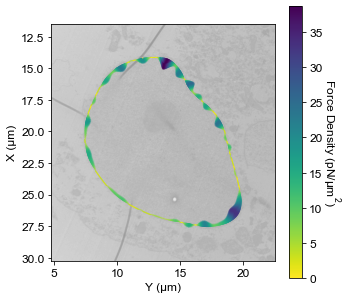

Processing 34D-grid3-ActA1_004_16
[ 3.45680085 21.59233147] [12.93549497 30.91957211]


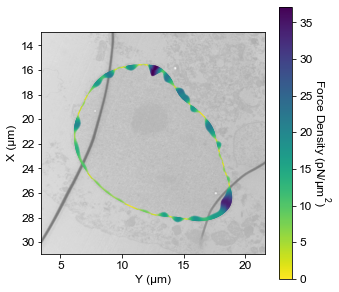

In [6]:
cm = mpl.cm.viridis_r
padding = 2  # padding to add around cell boundary to give broader image context

for file in files:
    k = file.stem
    d = data[k]
    print(f"Processing {k}")

    original_coords = d["original_coords"]
    relaxed_coords = d["relaxed_coords"]
    forces = d["relaxed_forces"]
    dualLengths = d["dualLengths"]
    f_mag = np.linalg.norm(forces, axis=1)

    norm = mpl.colors.Normalize(vmin=f_mag.min(), vmax=f_mag.max())
    # Map values to colors and add vertex color layer
    colors = cm(norm(f_mag))

    # with Image.open(f"crop_images/{k}.png") as im:
    with Image.open(f"raw_images/{k}.TIF") as im:
        pixel_scale = images[k]

        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        # ax.plot(original_coords[:, 0], original_coords[:, 1], color="r")
        # ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1], color="gray", zorder=1)
        ax.set_aspect('equal')

        Q = ax.quiver(
            relaxed_coords[:, 0],
            relaxed_coords[:, 1],
            forces[:, 0],
            forces[:, 1],
            f_mag,
            cmap=cm,
            angles="xy",
            units="xy",
            label="force",
            scale=4e1,
            scale_units="xy",
            width=0.1,
            zorder=10,
        )
        ax.set_ylabel(r"X (μm)")
        ax.set_xlabel(r"Y (μm)")

        x_lim = np.array(ax.get_xlim()) + [-padding, padding]
        y_lim = np.array(ax.get_ylim()) + [-padding, padding]

        print(x_lim, y_lim)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)

        x_lim_pix = (x_lim / pixel_scale).round()
        y_lim_pix = (y_lim / pixel_scale).round()

        ax.set_ylim(ax.get_ylim()[::-1])

        im = im.crop((x_lim_pix[0], y_lim_pix[0], x_lim_pix[1], y_lim_pix[1]))

        plt.imshow(
            im,
            alpha=0.6,
            extent=(x_lim[0], x_lim[1], y_lim[1], y_lim[0]),
            zorder=0,
            cmap=plt.cm.Greys_r,
        )

        # Shrink current axis
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cm), ax=ax)
        cbar.ax.get_yaxis().labelpad = 20
        cbar.ax.set_ylabel("Force Density ($\mathregular{pN/\mu m^2}$)", rotation=270)

        # Quiver key draws length of arrow
        # qk = ax.quiverkey(Q, 0.45, 0.8, 500, r'$500 \frac{pN}{\mu m^2}$', labelpos='E', coordinates='figure')

        plt.savefig(f"figures/{file.stem}_force.pdf")
        plt.show()


Processing 34D-grid2-s3-acta1_001_16


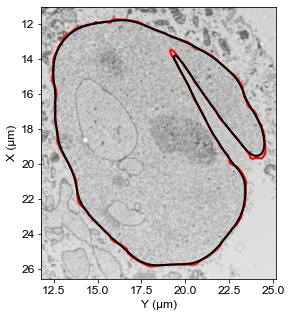

Processing 34D-grid3-ActA1_007_16


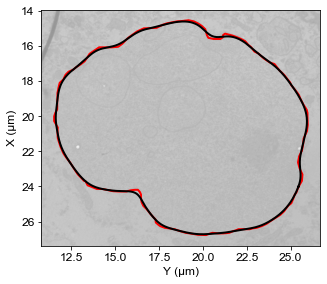

Processing 34D-grid3-ActA1_013_16


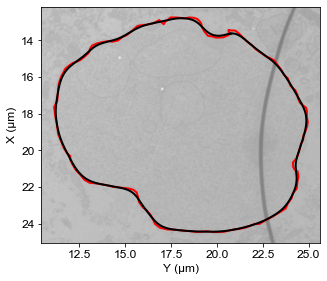

Processing 34D-grid2-s2_002_16


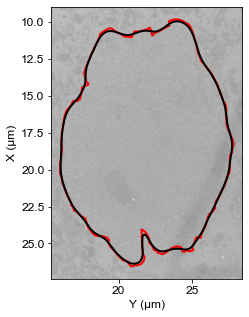

Processing 34D-grid2-s5_005_16


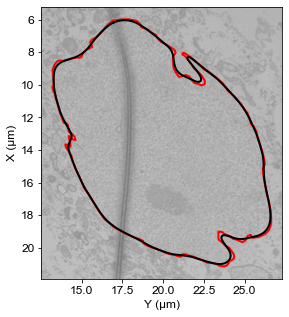

Processing 34D-grid3-ActA1_020_16


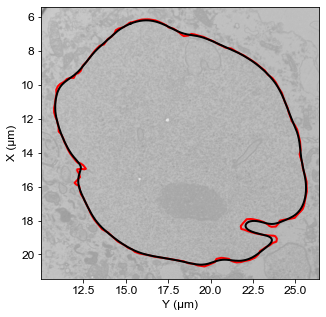

Processing 34D-grid3-s6_005_16


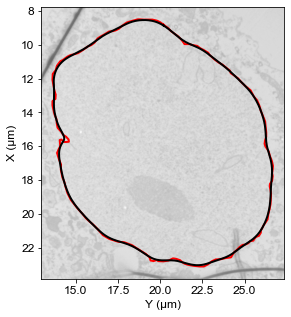

Processing 34D-grid2-s3_028_16


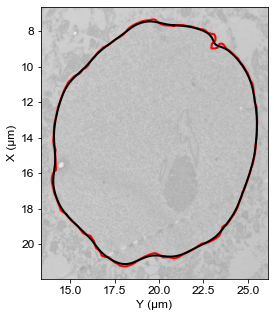

Processing 34D-grid3-ActA1_001_16


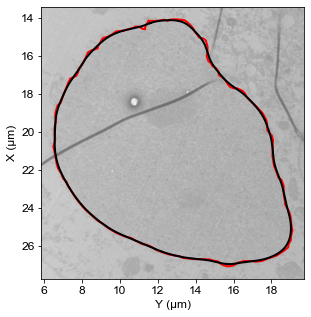

Processing 34D-grid3-ActA1_002_16


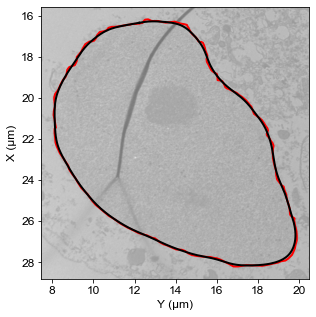

Processing 34D-grid3-ActA1_003_16


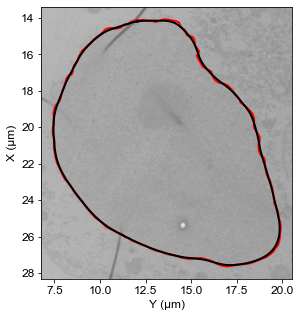

Processing 34D-grid3-ActA1_004_16


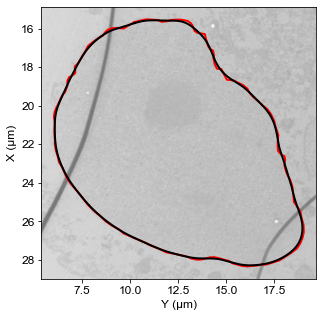

In [7]:
cm = mpl.cm.viridis_r

for file in files:
    k = file.stem
    d = data[k]
    print(f"Processing {k}")

    original_coords = d["original_coords"]
    relaxed_coords = d["relaxed_coords"]
    forces = d["relaxed_forces"]
    dualLengths = d["dualLengths"]
    f_mag = np.linalg.norm(forces, axis=1)

    norm = mpl.colors.Normalize(vmin=f_mag.min(), vmax=f_mag.max())
    # Map values to colors and add vertex color layer
    colors = cm(norm(f_mag))

    # with Image.open(f"crop_images/{k}.png") as im:
    with Image.open(f"raw_images/{k}.TIF") as im:
        pixel_scale = images[k]

        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        ax.plot(original_coords[:, 0], original_coords[:, 1], color="k")
        ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1], color="r", zorder=10)
        ax.set_ylabel(r"X (μm)")
        ax.set_xlabel(r"Y (μm)")

        x_lim = np.array(ax.get_xlim())
        y_lim = np.array(ax.get_ylim())

        x_lim_pix = (x_lim / pixel_scale).round()
        y_lim_pix = (y_lim / pixel_scale).round()

        ax.set_ylim(ax.get_ylim()[::-1])

        im = im.crop((x_lim_pix[0], y_lim_pix[0], x_lim_pix[1], y_lim_pix[1]))

        plt.imshow(
            im, alpha=0.6, extent=(x_lim[0], x_lim[1], y_lim[1], y_lim[0]), zorder=0, cmap = plt.cm.Greys_r
        )

        # Shrink current axis
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        # cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cm), ax=ax)
        # cbar.ax.get_yaxis().labelpad = 20
        # cbar.ax.set_ylabel("Force Density ($\mathregular{pN/\mu m^2}$)", rotation=270)

        plt.savefig(f"figures/{file.stem}_force.pdf")
        plt.show()


In [8]:
for file in files:
    k = file.stem
    d = data[k]

    original_coords = d["original_coords"]
    relaxed_coords = d["relaxed_coords"]
    forces = d["relaxed_forces"]
    dualLengths = d["dualLengths"]

    print(
        "Mean dual length:",
        np.mean(dualLengths),
        "μm;",
        np.mean(dualLengths) ** 2,
        "μm^2",
    )


Mean dual length: 0.04804882083064279 μm; 0.0023086891832152126 μm^2
Mean dual length: 0.048147567012518405 μm; 0.0023181882092249504 μm^2
Mean dual length: 0.047595512356237206 μm; 0.0022653327964527285 μm^2
Mean dual length: 0.04535505438411401 μm; 0.0020570809581859396 μm^2
Mean dual length: 0.044352742362349276 μm; 0.001967165755060932 μm^2
Mean dual length: 0.046639018390590925 μm; 0.0021751980364378785 μm^2
Mean dual length: 0.04764800522050364 μm; 0.0022703324014931425 μm^2
Mean dual length: 0.04762511069002528 μm; 0.0022681511682371602 μm^2
Mean dual length: 0.04809270871578404 μm; 0.0023129086316212503 μm^2
Mean dual length: 0.04815049921346806 μm; 0.0023184705745061883 μm^2
Mean dual length: 0.048446529073020786 μm; 0.0023470661792230484 μm^2
Mean dual length: 0.04838270805683307 μm; 0.0023408864389127394 μm^2


Assuming an actin filament is ~7nm in diameter a conservative surface area occupancy is 49 $\mathrm{nm^2}$ or 4.9e-5 $\mathrm{\mu m^2}$. Depending on cell conditions a single actin filament can produce ~1 pN of force.

Then 1pN * A / 4.9e-5 μm^2 gives the maximum force assuming full surface coverage by pushing actin.


